# Задача 9. Hand-crafted graph features

* **Дедлайн**: 16.05.2025, 23:59
* Основной полный балл: 5
* Максимум баллов: 10


## Задача

- [x] Найти или сгенерировать набор данных для бинарной классификации графов.
- [x] Реализовать функцию `shortest_path_kernel(train_graphs, test_graphs)`, которая принимает тренировочный и тестовые наборы, а возвращает пару `K_train, K_test`
  - Опишите графы с помощью вектора из количества кратчайших путей различной длины
  - Для вычисления длин кратчайших путей можно использовать `nx.shortest_path_length(G)`
  - Ядровая функция для сравнения двух графов - скалярное произведение их двух векторов
  - `K_train` - матрица из ядровых функций для сравнения тренировочных графов между собой
  - `K_test` - матрица из ядровых функций для сравнения тестовых графов с тренировочными
- [x] Используя реализованное ядро обучите модель SVC, подберите гиперпараметры, вычислите различные метрики качества
- [x] (+5 баллов) Также реализовать Weisfeiler-Lehman Kernel и обучить классификатор с ним, сравнить результаты.

### Найти или сгенерировать набор данных для бинарной классификации графов.

In [293]:
def generate_graph_dataset(n_graphs=50, n_nodes=15):
    graphs = []
    labels = []

    for _ in range(n_graphs):
        # Класс 0: случайные графы Erdos-Renyi
        G = nx.erdos_renyi_graph(n_nodes, p=0.3)
        graphs.append(G)
        labels.append(0)

        # Класс 1: графы Barabasi-Albert
        G = nx.barabasi_albert_graph(n_nodes, m=2)
        graphs.append(G)
        labels.append(1)

    return graphs, labels

graphs, labels = generate_graph_dataset(200)
print(len(graphs), labels[:10])

400 [0, 1, 0, 1, 0, 1, 0, 1, 0, 1]


In [294]:
from sklearn.model_selection import train_test_split

# graphs, labels — наш сгенерированный набор
train_graphs, test_graphs, y_train, y_test = train_test_split(
    graphs, labels, test_size=0.3, random_state=42, stratify=labels
)

print(f"Train graphs: {len(train_graphs)}, Test graphs: {len(test_graphs)}")
print(f"Train labels sample: {y_train[:10]}")

Train graphs: 280, Test graphs: 120
Train labels sample: [1, 0, 1, 0, 1, 1, 1, 1, 1, 0]


In [295]:
import numpy as np

unique, counts = np.unique(y_test, return_counts=True)
for cls, count in zip(unique, counts):
    print(f"Class {cls}: {count} graphs")

Class 0: 60 graphs
Class 1: 60 graphs


### Реализовать функцию `shortest_path_kernel(train_graphs, test_graphs)`

In [296]:
import networkx as nx
from collections import Counter

def graph_to_sp_vector(G):
    lengths = []
    for _, dist_dict in nx.shortest_path_length(G):
        lengths.extend(dist_dict.values())

    counter = Counter(lengths)
    max_length = max(counter.keys())

    vector = np.array([counter[i] for i in range(max_length + 1)])
    return vector

def shortest_path_kernel(train_graphs, test_graphs):
    train_vectors = [graph_to_sp_vector(graph) for graph in train_graphs]
    test_vectors = [graph_to_sp_vector(graph) for graph in test_graphs]

    max_len = max(max(len(v) for v in train_vectors), max(len(v) for v in test_vectors))
    train_vectors = [np.pad(v, (0, max_len - len(v))) for v in train_vectors]
    test_vectors = [np.pad(v, (0, max_len - len(v))) for v in test_vectors]

    K_train = np.array([[np.dot(v1, v2) for v2 in train_vectors] for v1 in train_vectors])
    K_test  = np.array([[np.dot(v1, v2) for v2 in train_vectors] for v1 in test_vectors])

    return K_train, K_test

K_train, K_test = shortest_path_kernel(train_graphs, test_graphs)

### Используя реализованное ядро обучите модель SVC, подберите гиперпараметры, вычислите различные метрики качества

In [297]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

svc = SVC(kernel='precomputed', random_state=42)

param_grid = {
    'C': [0.1, 1, 10, 100],
    'gamma': ['scale', 'auto']
}

grid_shortest_path = GridSearchCV(svc, param_grid, cv=5, scoring='accuracy')
grid_shortest_path.fit(K_train, y_train)

print("Best score (SP): ", grid_shortest_path.best_score_)
print("Best param (SP): ", grid_shortest_path.best_params_)
print()

Best score (SP):  0.9535714285714285
Best param (SP):  {'C': 1, 'gamma': 'scale'}



In [298]:
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report

best_svc_shortest_path = grid_shortest_path.best_estimator_

y_res = best_svc_shortest_path.predict(K_test)

acc = accuracy_score(y_test, y_res)
f1 = f1_score(y_test, y_res)
cm = confusion_matrix(y_test, y_res)
report = classification_report(y_test, y_res)

print("Accuracy:", acc)
print("F1 score:", f1)
print("Confusion matrix:\n", cm)
print()
print("Classification report:\n", report)
data_shortest_path = ["shortest_path", grid_shortest_path.best_score_, grid_shortest_path.best_params_, acc, f1]

Accuracy: 0.95
F1 score: 0.9523809523809523
Confusion matrix:
 [[54  6]
 [ 0 60]]

Classification report:
               precision    recall  f1-score   support

           0       1.00      0.90      0.95        60
           1       0.91      1.00      0.95        60

    accuracy                           0.95       120
   macro avg       0.95      0.95      0.95       120
weighted avg       0.95      0.95      0.95       120



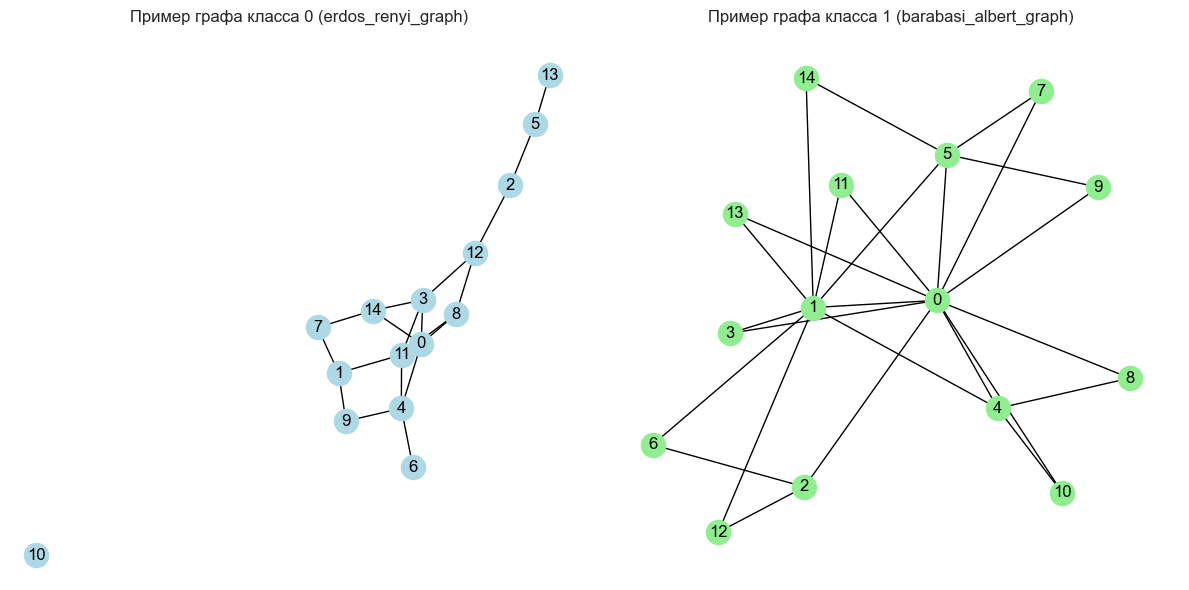

In [299]:
from matplotlib import pyplot as plt

plt.figure(figsize=(12, 6))

# Графы класса 0 (erdos_renyi_graph)
plt.subplot(1, 2, 1)
class0_graphs = [G for G, label in zip(train_graphs, y_train) if label == 0]
nx.draw(class0_graphs[0], with_labels=True, node_color='lightblue')
plt.title("Пример графа класса 0 (erdos_renyi_graph)")

# Графы класса 1 (barabasi_albert_graph)
plt.subplot(1, 2, 2)
class1_graphs = [G for G, label in zip(train_graphs, y_train) if label == 1]
nx.draw(class1_graphs[0], with_labels=True, node_color='lightgreen')
plt.title("Пример графа класса 1 (barabasi_albert_graph)")

plt.tight_layout()
plt.show()

Визуально разницу не видно, но за счет разной логики построения графов, они обладают некоторыми различиями.

## erdos_renyi_graph

# Создание: nx.erdos_renyi_graph(n, p)
n — число вершин
p — вероятность появления каждого ребра между двумя вершинами

# Свойства:
Каждый возможный ребро добавляется независимо с вероятностью p.
Степени вершин распределены примерно по биномиальному закону (на больших графах → почти по Пуассону).
Структура равномерная, нет «центров» с большим числом связей.

# Визуальный эффект:
Вершины примерно равномерно соединены.
Нет ярко выраженных «хабов» (узлов с огромным числом связей).

## barabasi_albert_graph

# Создание: nx.barabasi_albert_graph(n, m)
n — число вершин
m — число рёбер, которое добавляется для каждой новой вершины

# Свойства:
Механизм preferential attachment («богатые становятся богаче»): новые вершины с большей вероятностью соединяются с уже популярными вершинами.
Степени вершин распределены по степенному закону: мало вершин с очень высокой степенью (хабы) и много вершин с малой степенью.
Образуется scale-free network.

# Визуальный эффект:
Появляются ярко выраженные «хабы» — вершины с множеством связей.
Большинство вершин имеют всего несколько соединений.

# P.S.
На самом деле, для алгоритма barabasi_albert_graph m = 2, которое мы взяли - хорошее значение для данной задачи. Можно заметить, что если взять m = 3, то предсказание ухудшится, такое значение приближает вероятность возникновения ребра к той же вероятности 0.3. При этом если взять сильно большое значение для m, то это улучшит предсказание. То есть самым сложным испытанием для модели SVC будут графы, с такими подобранными значениями p и m(зависящими от кол-ва вершин), чтобы среднее количество ребер у вершин стремилось к равенству.

### Также реализовать Weisfeiler-Lehman Kernel и обучить классификатор с ним, сравнить результаты.

In [300]:
def weisfeiler_lehman_counter(G, h=2):
    """Для одного графа возвращает все метки на всех итерациях и их кол-во"""
    labels = {v: str(G.degree(v)) for v in G.nodes()}
    all_labels = Counter(labels.values())

    for iteration in range(h):
        new_labels = {}
        for v in G.nodes():
            neighbor_labels = sorted(labels[n] for n in G.neighbors(v))
            new_label = labels[v] + "_" + "_".join(neighbor_labels)
            new_labels[v] = new_label
        labels = new_labels
        all_labels.update(labels.values())
    return all_labels

def weisfeiler_lehman_keys_decomp(graphs, h=2):
    graph_values = []
    unique_labels = set()
    for G in graphs:
        wl_counter = weisfeiler_lehman_counter(G, h)
        graph_values.append(wl_counter)
        unique_labels.update(set(wl_counter.keys()))

    return graph_values, unique_labels

def weisfeiler_lehman_graph_vectors(graphs, unique_labels, h=2):
    vectors = []
    for graph in graphs:
        vector = np.array([graph.get(label, 0) for label in unique_labels])
        vectors.append(vector)

    return vectors

def weisfeiler_lehman_kernel(train_graphs, test_graphs, h=2):
    train_graph_values, train_unique_labels = weisfeiler_lehman_keys_decomp(train_graphs, h)
    test_graph_values, test_unique_labels = weisfeiler_lehman_keys_decomp(test_graphs, h)

    unique_labels = sorted(train_unique_labels.union(test_unique_labels))

    train_vectors = weisfeiler_lehman_graph_vectors(train_graph_values, unique_labels)
    test_vectors = weisfeiler_lehman_graph_vectors(test_graph_values, unique_labels)

    K_train = np.array([[np.dot(v1, v2) for v2 in train_vectors] for v1 in train_vectors])
    K_test  = np.array([[np.dot(v1, v2) for v2 in train_vectors] for v1 in test_vectors])

    return K_train, K_test

K_train, K_test = weisfeiler_lehman_kernel(train_graphs, test_graphs)

In [301]:
svc = SVC(kernel='precomputed', random_state=42)

param_grid = {
    'C': [0.1, 1, 10, 100],
    'gamma': ['scale', 'auto']
}

grid_weisfeiler_lehman = GridSearchCV(svc, param_grid, cv=5, scoring='accuracy')
grid_weisfeiler_lehman.fit(K_train, y_train)

print("Best score (SP): ", grid_weisfeiler_lehman.best_score_)
print("Best param (SP): ", grid_weisfeiler_lehman.best_params_)
print()

Best score (SP):  0.9642857142857142
Best param (SP):  {'C': 0.1, 'gamma': 'scale'}



In [302]:
best_svc_weisfeiler_lehman = grid_weisfeiler_lehman.best_estimator_

y_res = best_svc_weisfeiler_lehman.predict(K_test)

acc = accuracy_score(y_test, y_res)
f1 = f1_score(y_test, y_res)
cm = confusion_matrix(y_test, y_res)
report = classification_report(y_test, y_res)

print("Accuracy:", acc)
print("F1 score:", f1)
print("Confusion matrix:\n", cm)
print()
print("Classification report:\n", report)
data_weisfeiler_lehman = ["weisfeiler_lehman", grid_weisfeiler_lehman.best_score_, grid_weisfeiler_lehman.best_params_, acc, f1]

Accuracy: 0.975
F1 score: 0.9752066115702479
Confusion matrix:
 [[58  2]
 [ 1 59]]

Classification report:
               precision    recall  f1-score   support

           0       0.98      0.97      0.97        60
           1       0.97      0.98      0.98        60

    accuracy                           0.97       120
   macro avg       0.98      0.97      0.97       120
weighted avg       0.98      0.97      0.97       120



In [303]:
import pandas as pd

df_results = pd.DataFrame([data_weisfeiler_lehman,data_shortest_path] , columns=[
    "kernel", "best_cv_score", "best_params", "test_acc", "test_f1"
])
df_results

,kernel,best_cv_score,best_params,test_acc,test_f1
0,weisfeiler_lehman,0.964286,"{'C': 0.1, 'gamma': 'scale'}",0.975,0.975207
1,shortest_path,0.953571,"{'C': 1, 'gamma': 'scale'}",0.950,0.952381


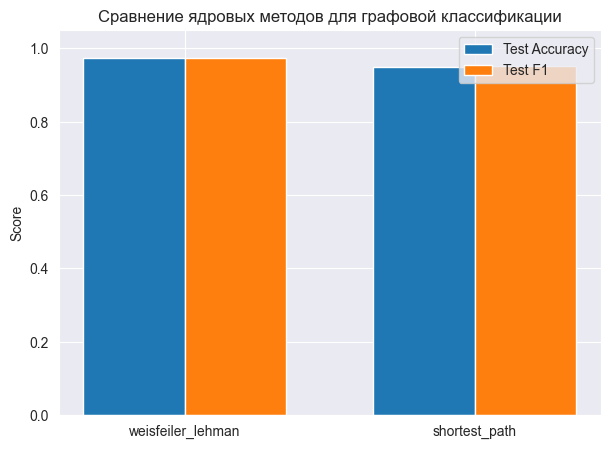

In [304]:
x = np.arange(len(df_results["kernel"]))
width = 0.35

fig, ax = plt.subplots(figsize=(7, 5))
ax.bar(x - width/2, df_results["test_acc"], width, label='Test Accuracy')
ax.bar(x + width/2, df_results["test_f1"], width, label='Test F1')

ax.set_xticks(x)
ax.set_xticklabels(df_results["kernel"])
ax.set_ylim(0, 1.05)
ax.set_ylabel('Score')
ax.set_title('Сравнение ядровых методов для графовой классификации')
ax.legend()
plt.show()

WL kernel выше по обеим метрикам. Хоть и не значительно.

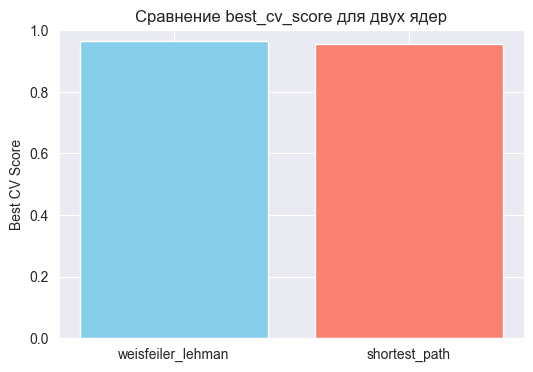

In [305]:
x = np.arange(len(df_results["kernel"]))
plt.figure(figsize=(6, 4))
plt.bar(x, df_results["best_cv_score"], color=['skyblue', 'salmon'])
plt.xticks(x, df_results["kernel"])
plt.ylim(0, 1)
plt.ylabel("Best CV Score")
plt.title("Сравнение best_cv_score для двух ядер")
plt.show()

WL kernel так же не значительно выше